1.1 Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# displays all the columns
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (18, 8);

In [3]:
df=pd.read_csv('handling_missing_values_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

We have 81 columns in total, 80 of them are feature columns and SalePrice is the target column

In [4]:
feature_cols = [col for col in df.columns if col not in ['SalePrice']]
target_cols = ['SalePrice']

cat_cols = [col for col in feature_cols if df[col].dtype == 'O']
cont_cols = [col for col in feature_cols if col not in cat_cols]

<Axes: >

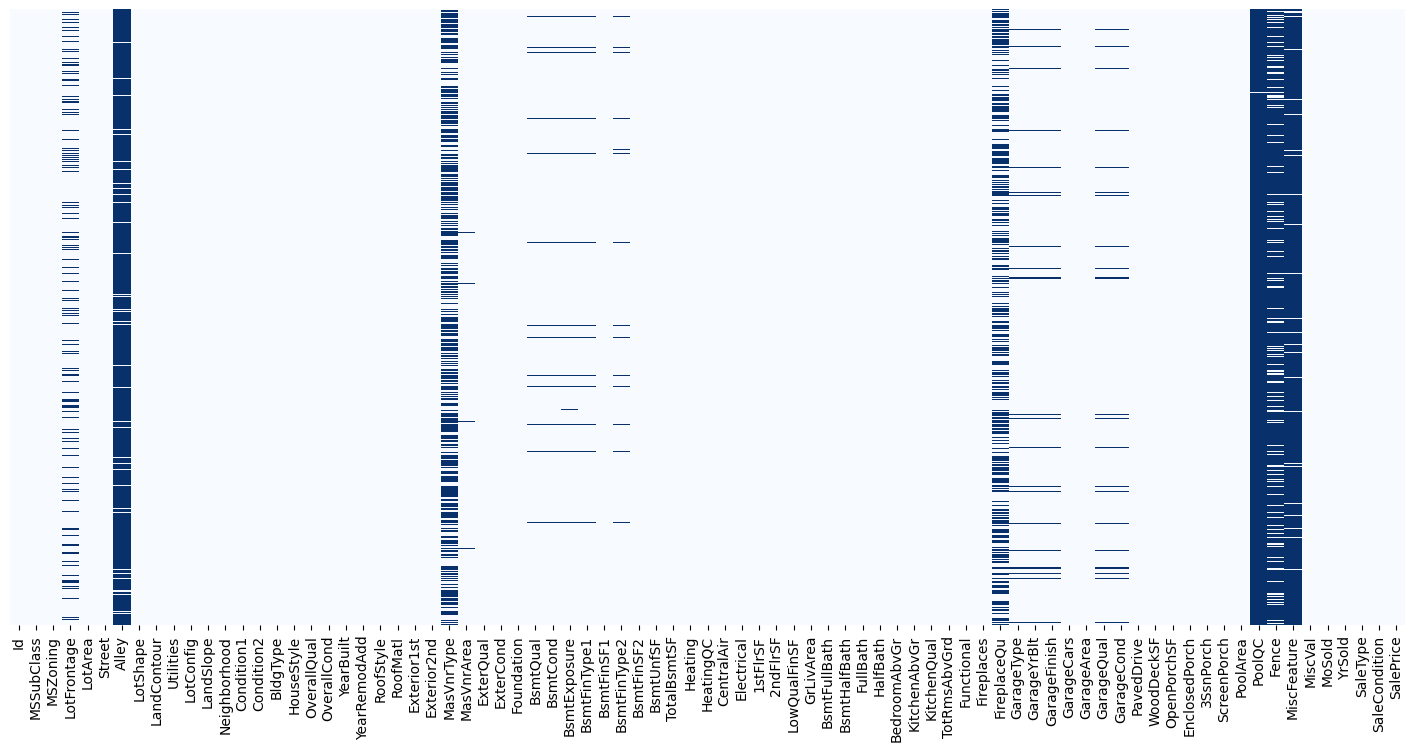

In [5]:
sns.heatmap(df.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=df.columns)


1.3 Helper Function

In [6]:
def encode_missing_columns(df, col):
    le = LabelEncoder()
    
    # gets unique values w/o NaN
    unique_without_nan = pd.Series([i for i in df[col].unique() if type(i) == str])
    le.fit(unique_without_nan) # Fit on unique values
    
    # Set transformed col leaving np.NaN as they are
    df[col] = df[col].apply(lambda x: le.transform([x])[0] if type(x) == str else x)

Let's take an example to understand what this function is doing
Suppose we have a column ['apple', 'mango', 'banana', 'apple', 'banana', NaN]

In [8]:
demo_col = pd.Series(['apple', 'mango', 'banana', 'apple', 'banana', np.nan])
print(f'Unique Values in the Column: {demo_col.unique()}')
print(f'Unique Values of type string: {[i for i in demo_col.unique() if type(i) == str]}')

Unique Values in the Column: ['apple' 'mango' 'banana' nan]
Unique Values of type string: ['apple', 'mango', 'banana']


In [9]:
le = LabelEncoder()
unique_without_nan = pd.Series([i for i in demo_col.unique() if type(i) == str])
le.fit(unique_without_nan)
demo_col.apply(lambda x: le.transform([x])[0] if type(x) == str else x)

0    0.0
1    2.0
2    1.0
3    0.0
4    1.0
5    NaN
dtype: float64

2 Dropping Rows and Columns
This isn't an imputation technique, but this might be the first thing that comes in mind to deal with missing values


2.1 Dropping Rows with Missing Values

In [10]:
sum(df.isna().sum(axis=1) > 0)

1460

If we drop all the rows with any missing value we aren't left with any row


2.2 Dropping Columns with Missing Values

In [11]:
sum(df.isna().sum(axis=0) > 0)

19